# RFM Analysis
### Method 1: using Python's groupby() function

In [1]:
# RFM Analysis
## Import appropriate modules
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.style.use('seaborn-white')
import seaborn as sns 
import datetime as dt

<Figure size 720x576 with 0 Axes>

In [2]:
df = pd.read_excel('data_for_RFM_score_analysis.xlsx', parse_dates=['date'])
print(df.head())

                                     id       date   sales
0  000173c5-978c-4b52-b7a4-5ebf974deb86 2020-08-13  1690.0
1  000173c5-978c-4b52-b7a4-5ebf974deb86 2020-08-14  6145.0
2  000173c5-978c-4b52-b7a4-5ebf974deb86 2020-08-15  4550.0
3  000173c5-978c-4b52-b7a4-5ebf974deb86 2020-08-17  1270.0
4  000173c5-978c-4b52-b7a4-5ebf974deb86 2020-08-20  3830.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804659 entries, 0 to 804658
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   id      804659 non-null  object        
 1   date    804659 non-null  datetime64[ns]
 2   sales   804659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 18.4+ MB


### Generating Summary Statistics: 
### Method 1:

In [4]:
def describe(df):
    return pd.concat([df.describe().T,
                      df.mad().rename('mad'),# mean absolute deviation
                      df.skew().rename('skew'), # skewness
                      df.kurt().rename('kurt'), # kurtosis
                     ], axis=1).T
RFM_Summary_Stats = describe(df)
print(RFM_Summary_Stats)
# RFM_Summary_Stats.to_excel('RFM_Summary_Statistics+Table.xlsx') # Save the Summary Stats to an excel table

              sales
count  8.046590e+05
mean   2.993685e+03
std    9.990926e+03
min    1.000000e+00
25%    8.200000e+02
50%    1.540000e+03
75%    3.090000e+03
max    3.242380e+06
mad    2.495390e+03
skew   1.371458e+02
kurt   3.461725e+04


### Method 2

In [5]:
stats = df.describe()
## appending interquartile range instead of recalculating it
stats.loc['IQR'] = stats.loc['75%'] - stats.loc['25%'] 
stats = stats.append(df.reindex(stats.columns, axis=1).agg(['skew', 'mad', 'kurt']))
print(stats)

              sales
count  8.046590e+05
mean   2.993685e+03
std    9.990926e+03
min    1.000000e+00
25%    8.200000e+02
50%    1.540000e+03
75%    3.090000e+03
max    3.242380e+06
IQR    2.270000e+03
skew   1.371458e+02
mad    2.495390e+03
kurt   3.461725e+04


## Creating the RFM Table

In [7]:
## Getting first and last order date
print("Minimum Date: ", df['date'].min(), "Maximum Date: ", df['date'].max()) # Min Date:  2020-04-01 00:00:00 Max Date:  2020-09-25 00:00:00
'''
In the dataset, the last delivery date is September 25, 2020, we have use this date plus 1 day as NOW date to calculate recency.
'''
NOW = df['date'].max() + dt.timedelta(days=1)
print('Current Date: ', NOW)

Minimum Date:  2020-04-01 00:00:00 Maximum Date:  2020-09-25 00:00:00
Current Date:  2020-09-26 00:00:00


In [8]:
rfm_table = df.groupby('id').agg(
                                    {'date': lambda x: (NOW - x.max()).days, # Recency
                                     'id': lambda x: len(x), # Frequency
                                     'sales': lambda x: x.sum() # Monetary
                                     }
                                    )
rfm_table['date'] = rfm_table['date'].astype(int)
rfm_table.rename(columns = {'date': 'recency',
                            'id': 'frequency',
                            'sales': 'monetary_value'}, inplace = True)
                            
# Now, we have RFM values with respect to each customer
rfm_table.to_excel('Report_RFM_Table.xlsx')
print(rfm_table.head())

                                      recency  frequency  monetary_value
id                                                                      
000173c5-978c-4b52-b7a4-5ebf974deb86        1         54        149415.0
0001b0ce-f323-49b5-b381-3348c7a001ab        1         54        266800.0
00020337-5321-4d6e-83af-67905edd8006        8          4         13385.0
00066d09-6e2e-4104-b03b-6927490e1972       16         84         75388.0
00069d0b-c994-4555-a30e-0c0799d77fe1       10         48         75630.0


#### RFM Table Summary Statistics

In [10]:
# Summary Statistics for our RFM Table
def describe(rfm_table):
    return pd.concat([rfm_table.describe().T,
                      # mean absolute deviation
                      rfm_table.mad().rename('mad'),
                      rfm_table.skew().rename('skew'),
                      rfm_table.kurt().rename('kurt'),
                     ], axis=1).T
print(describe(rfm_table))

            recency     frequency  monetary_value
count  34897.000000  34897.000000    3.489700e+04
mean      31.231395     23.058114    6.902874e+04
std       41.530460     29.689213    2.673607e+05
min        1.000000      1.000000    3.000000e+01
25%        2.000000      3.000000    3.740000e+03
50%       10.000000     10.000000    1.888000e+04
75%       49.000000     32.000000    6.940000e+04
max      178.000000    153.000000    4.098779e+07
mad       32.495699     22.141035    7.829604e+04
skew       1.600389      1.852403    1.041778e+02
kurt       1.789147      3.114361    1.573369e+04


#### Defining Quantiles

In [11]:
quantiles = rfm_table.quantile(q = [0.25, 0.5, 0.75])
# Converting quantiles to a dictionary, easier to use.
quantiles = quantiles.to_dict()
print(quantiles)

{'recency': {0.25: 2.0, 0.5: 10.0, 0.75: 49.0}, 'frequency': {0.25: 3.0, 0.5: 10.0, 0.75: 32.0}, 'monetary_value': {0.25: 3740.0, 0.5: 18880.0, 0.75: 69400.0}}


#### RFM Segmentation

In [12]:
## RFM Segmentation
RFM_Segment = rfm_table.copy()
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4


RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary_value'].apply(FM_Class, args=('monetary_value',quantiles,))

RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str)  + RFM_Segment.F_Quartile.map(str)  + RFM_Segment.M_Quartile.map(str)
RFM_Segment = RFM_Segment.sort_values(by = ['RFMClass', 'monetary_value'], ascending = [True, False])

# save Excel file
RFM_Segment.to_excel('Report_RFM_Segments.xlsx')
print(RFM_Segment.head())

                                      recency  frequency  monetary_value  \
id                                                                         
09551734-92d5-447f-9f82-8de56d42b151      119          2          3740.0   
21475635-8057-4832-82e2-e54e0d0e470d      105          3          3740.0   
6357c08a-5c62-4db0-83e6-7c717011d010       59          1          3740.0   
76b50471-312c-4ca4-87aa-3718a6898992       74          2          3740.0   
b92be6cc-f90b-4b9f-9dbb-05607de35be9       52          3          3730.0   

                                      R_Quartile  F_Quartile  M_Quartile  \
id                                                                         
09551734-92d5-447f-9f82-8de56d42b151           1           1           1   
21475635-8057-4832-82e2-e54e0d0e470d           1           1           1   
6357c08a-5c62-4db0-83e6-7c717011d010           1           1           1   
76b50471-312c-4ca4-87aa-3718a6898992           1           1           1   
b92be6cc-f9

In [13]:
'''
Another possibility is to combine the scores to create one score (eg. 4+1+1). 
This will create a score between 3 and 12. Here the advantage is that each of the scores got same importance. 
However some scores will have many segements as constituents (eg - 413 ad 431)
'''
RFM_Segment['TotalScore'] = RFM_Segment['R_Quartile'] + RFM_Segment['F_Quartile'] + RFM_Segment['M_Quartile']
# save to excel
RFM_Segment.to_excel('Report_RFM_Segments.xlsx')
print(RFM_Segment.head())

## Example
print(RFM_Segment.groupby('TotalScore').agg('monetary_value').mean())

                                      recency  frequency  monetary_value  \
id                                                                         
09551734-92d5-447f-9f82-8de56d42b151      119          2          3740.0   
21475635-8057-4832-82e2-e54e0d0e470d      105          3          3740.0   
6357c08a-5c62-4db0-83e6-7c717011d010       59          1          3740.0   
76b50471-312c-4ca4-87aa-3718a6898992       74          2          3740.0   
b92be6cc-f90b-4b9f-9dbb-05607de35be9       52          3          3730.0   

                                      R_Quartile  F_Quartile  M_Quartile  \
id                                                                         
09551734-92d5-447f-9f82-8de56d42b151           1           1           1   
21475635-8057-4832-82e2-e54e0d0e470d           1           1           1   
6357c08a-5c62-4db0-83e6-7c717011d010           1           1           1   
76b50471-312c-4ca4-87aa-3718a6898992           1           1           1   
b92be6cc-f9

# Questions 7 Answers of Interests
RFM segmentation readily answers these questions for your business…:

* Who are my best customers?
* Which customers are at the verge of churning?
* Who are lost customers that you don’t need to pay much attention to?
* Who are your loyal customers?
* Which customers you must retain?
* Who has the potential to be converted into more profitable customers?
* Which group of customers is most likely to respond to your current campaign?

In [14]:
## 1. Q. Who are my best customers?
print(RFM_Segment[RFM_Segment['RFMClass']=='444'].sort_values('monetary_value',  ascending=False).head())

                                      recency  frequency  monetary_value  \
id                                                                         
bf5fba85-3dde-487d-939c-bac7e11edc23        2         49      40987790.0   
64a4b216-ea96-4a4f-afd8-7f9f0713e2f4        1        153       2950117.0   
a84eeedd-17cc-4d15-be14-64e7d836719f        1        106       2727720.0   
bb39b7fa-6ef1-414c-902d-b22a96524cd2        1        112       2702289.0   
f517b839-4da2-4a38-80cb-33f67340c65b        1        118       2590070.0   

                                      R_Quartile  F_Quartile  M_Quartile  \
id                                                                         
bf5fba85-3dde-487d-939c-bac7e11edc23           4           4           4   
64a4b216-ea96-4a4f-afd8-7f9f0713e2f4           4           4           4   
a84eeedd-17cc-4d15-be14-64e7d836719f           4           4           4   
bb39b7fa-6ef1-414c-902d-b22a96524cd2           4           4           4   
f517b839-4d

In [15]:
## 2. Q. Which customers are at the verge of churning? i.e., Customers whose recency are low:
print(RFM_Segment[RFM_Segment['R_Quartile'] <= 2 ].sort_values('monetary_value', ascending=False).head(5))

                                      recency  frequency  monetary_value  \
id                                                                         
c002476e-6053-44d5-a6db-941f4fee89f4       11         10       3323104.0   
f2ce1018-a1e2-4481-98d2-fa67113e3845       23         50       2032185.0   
d04688c9-aa84-4990-b461-113382c77e02       61         43       1248965.0   
fd447d40-1bc2-4d80-9740-6149719c3f89       14         66       1169880.0   
1a79bb4c-345a-4b5a-b738-57aa04470daf       23         89       1011185.0   

                                      R_Quartile  F_Quartile  M_Quartile  \
id                                                                         
c002476e-6053-44d5-a6db-941f4fee89f4           2           2           4   
f2ce1018-a1e2-4481-98d2-fa67113e3845           2           4           4   
d04688c9-aa84-4990-b461-113382c77e02           1           4           4   
fd447d40-1bc2-4d80-9740-6149719c3f89           2           4           4   
1a79bb4c-34

In [16]:
## 3. Q. Who are the lost customers? ie.., Customers whose recency, frequency, as well as monetary values are low.
print(RFM_Segment[RFM_Segment['RFMClass']=='111'].sort_values('recency', ascending=False).head(5))

                                      recency  frequency  monetary_value  \
id                                                                         
abab8508-0a9d-4e17-b566-e5fc4f99fcef      178          1           400.0   
43f473a3-1382-4cba-a699-b199951a7a49      178          1           680.0   
76f58784-74bf-46d3-9fa4-a2996477cc20      178          1          1370.0   
fd863f6e-a505-4126-87c6-fd4156e2dddb      178          1          2600.0   
e21e9d11-3473-43c5-ae25-08011b4afc27      178          1           490.0   

                                      R_Quartile  F_Quartile  M_Quartile  \
id                                                                         
abab8508-0a9d-4e17-b566-e5fc4f99fcef           1           1           1   
43f473a3-1382-4cba-a699-b199951a7a49           1           1           1   
76f58784-74bf-46d3-9fa4-a2996477cc20           1           1           1   
fd863f6e-a505-4126-87c6-fd4156e2dddb           1           1           1   
e21e9d11-34

In [17]:
## 4. Q. Who are loyal customers? ie., Customers with _high frequency_ value
print(RFM_Segment[RFM_Segment['F_Quartile'] >= 3 ].sort_values('monetary_value', ascending=False).head(5))

                                      recency  frequency  monetary_value  \
id                                                                         
bf5fba85-3dde-487d-939c-bac7e11edc23        2         49      40987790.0   
382720c0-0549-457a-a8ce-81270e1b0410        3         98       4439875.0   
5534fa9b-6803-4d1b-a504-952a85f49f18        3        121       4119156.0   
9c49c1aa-38f6-41f4-b853-af33b4f3a1b9        5         56       3216465.0   
64a4b216-ea96-4a4f-afd8-7f9f0713e2f4        1        153       2950117.0   

                                      R_Quartile  F_Quartile  M_Quartile  \
id                                                                         
bf5fba85-3dde-487d-939c-bac7e11edc23           4           4           4   
382720c0-0549-457a-a8ce-81270e1b0410           3           4           4   
5534fa9b-6803-4d1b-a504-952a85f49f18           3           4           4   
9c49c1aa-38f6-41f4-b853-af33b4f3a1b9           3           4           4   
64a4b216-ea

### Visualizations

Text(0.5, 0, 'Total Score')

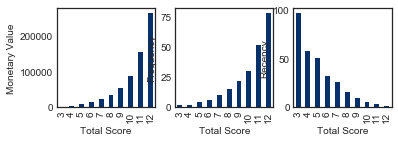

In [18]:
## Visualizations
ax1 = plt.subplot(2, 3, 1) # number of row = 1, number of columns = 2, subplot order = 1 
ax1 = RFM_Segment.groupby('TotalScore').agg('monetary_value').mean().plot(kind = 'bar', colormap = 'Blues_r')
ax1.set_ylabel('Monetary Value')
ax1.set_xlabel('Total Score')

ax2 = plt.subplot(2, 3, 2)
ax2 = RFM_Segment.groupby('TotalScore').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Total Score')

ax3 = plt.subplot(2, 3, 3)
ax3 = RFM_Segment.groupby('TotalScore').agg('recency').mean().plot(kind='bar', colormap='Blues_r')
ax3.set_ylabel('Recency')
ax3.set_xlabel('Total Score')